In [194]:
import numpy as np
import pandas as pd
import plotnine as pn

from datetime import datetime, date

from sciterra.mapping.atlas import Atlas
from sciterra.mapping.cartography import Cartographer
from sciterra.vectorization.scibert import SciBERTVectorizer

In [195]:
# atlas_dir = "outputs/atlas_s2-7-19-23_centered_imeletal/"
# atlas_dir = "outputs/atlas_s2-7-19-23_centered_hafenetal/"
# atlas_dir = "outputs/atlas_s2-7-20-23_uncentered_imeletal/"
# atlas_dir = "outputs/atlas_from_cc_region_0/"
# atlas_dir = "outputs/atlas_from_cc_region_8/"
# atlas_dir = "outputs/atlas_ads-7-25-23_hafenetal"
atlas_dir = "outputs/atlas_s2-7-29-23_centered_imeletal"

In [196]:
# load atlas
# convert all datetimes to dates
# filter all pubs without citations
# measure density
# measure citations per year
# plot density against citation frequency

In [197]:
atl = Atlas.load(atlas_dir)

In [198]:
len(atl)

10296

In [199]:
vectorizer = SciBERTVectorizer(device="mps")
crt = Cartographer(vectorizer=vectorizer)

Using device: mps.


In [200]:
measurements = crt.measure_topography(atl, metrics=["density", "edginess"])

Computing ['density', 'edginess'] for 10296 publications.


100%|██████████| 10296/10296 [00:07<00:00, 1355.44it/s]


In [201]:
citations_per_year = [ 
    atl[id].citation_count / (2023 - atl[id].publication_date.year) if (atl[id].publication_date.year < 2023 and atl[id].citation_count is not None) else 0.
    for id in atl.projection.index_to_identifier

]
# what if we just drop all those with 0 citations (per year)?
# and those > 100 anyway
citations_per_year = [item if (item > 0. and item < 100.) else None for item in citations_per_year ]
# citations_per_year

In [220]:
# count zeros, i.e. where citation_count was zero
len(citations_per_year) - np.count_nonzero(citations_per_year)

1409

In [221]:
df = pd.DataFrame(
    measurements,
    columns=["density", "edginess"],
)
df["citations_per_year"] = citations_per_year
df.dropna(inplace=True) # not sure why this didn't take care of later NaNs
df

density  edginess  citations_per_year
1      27.210708  0.689240           26.400000
2      26.671435  0.650981            1.500000
4      25.183372  0.672281           14.500000
5      32.191037  0.712823           14.000000
6      27.331261  0.668720           11.466667
...          ...       ...                 ...
10289  28.115950  0.739458            2.750000
10290  31.032678  0.642193            0.666667
10292  29.525302  0.714526            4.600000
10294  27.328128  0.705205           10.090909
10295  26.944869  0.730944            0.125000

[8750 rows x 3 columns]

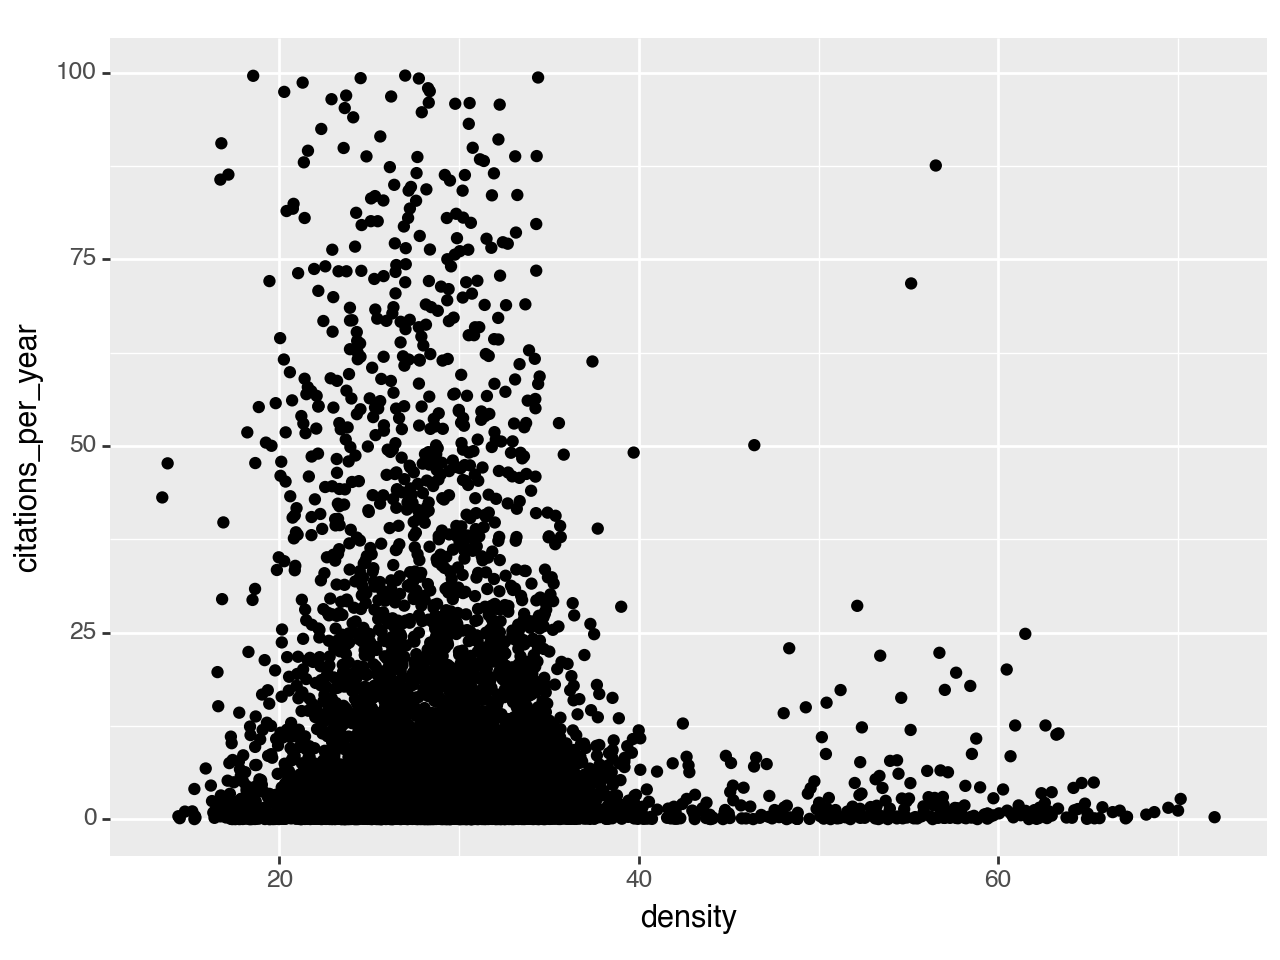

<Figure Size: (640 x 480)>

In [222]:
(
    pn.ggplot(
        df,
        mapping=pn.aes(x="density", y="citations_per_year")
    )
    + pn.geom_point()
    # + pn.geom_smooth(color="orange")
)

In [223]:
# let's additionally drop all points with density > 40, assuming those will get tossed out by convergence check.
df = df[df["density"] < 40.]
df

density  edginess  citations_per_year
1      27.210708  0.689240           26.400000
2      26.671435  0.650981            1.500000
4      25.183372  0.672281           14.500000
5      32.191037  0.712823           14.000000
6      27.331261  0.668720           11.466667
...          ...       ...                 ...
10289  28.115950  0.739458            2.750000
10290  31.032678  0.642193            0.666667
10292  29.525302  0.714526            4.600000
10294  27.328128  0.705205           10.090909
10295  26.944869  0.730944            0.125000

[8468 rows x 3 columns]

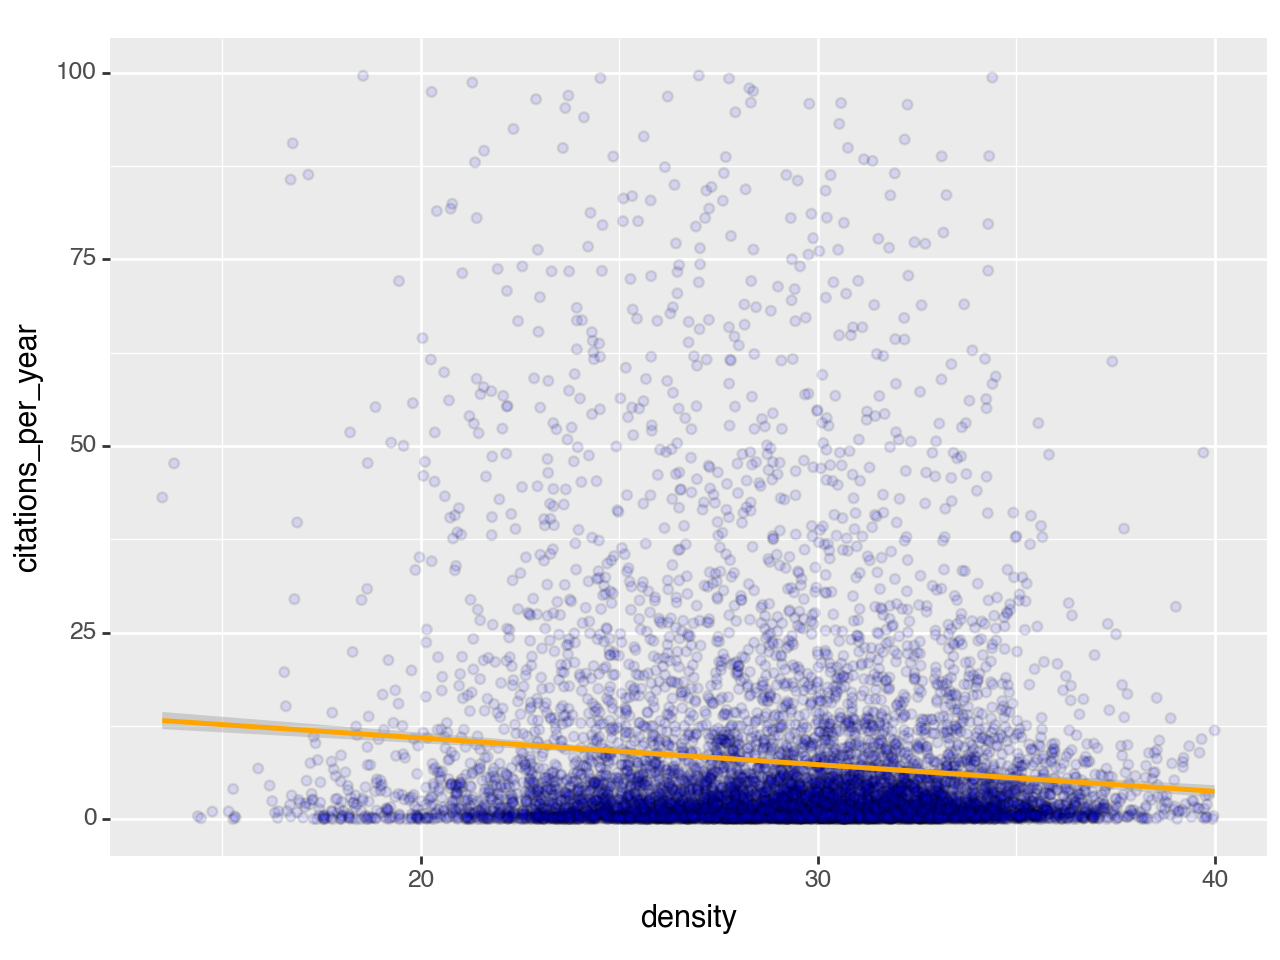

<Figure Size: (640 x 480)>

In [224]:
(
    pn.ggplot(
        df,
        mapping=pn.aes(x="density", y="citations_per_year")
    )
    + pn.geom_point(fill="blue", alpha=0.1,)
    + pn.geom_smooth(color="orange")
    # + pn.xlim(10, 18)
    # + pn.ylim(0, 100)
)

maybe the reason it seems like citations increase with density is actually not so interesting:

maybe it's that most papers just get few citations and are in the lower to mid range of density. Then when you get to higher density, there citation distribution just becomes more uniform. 

maybe. But why doesn't this argument apply in the other direction -- why does the citations not become more uniform at lower density?


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


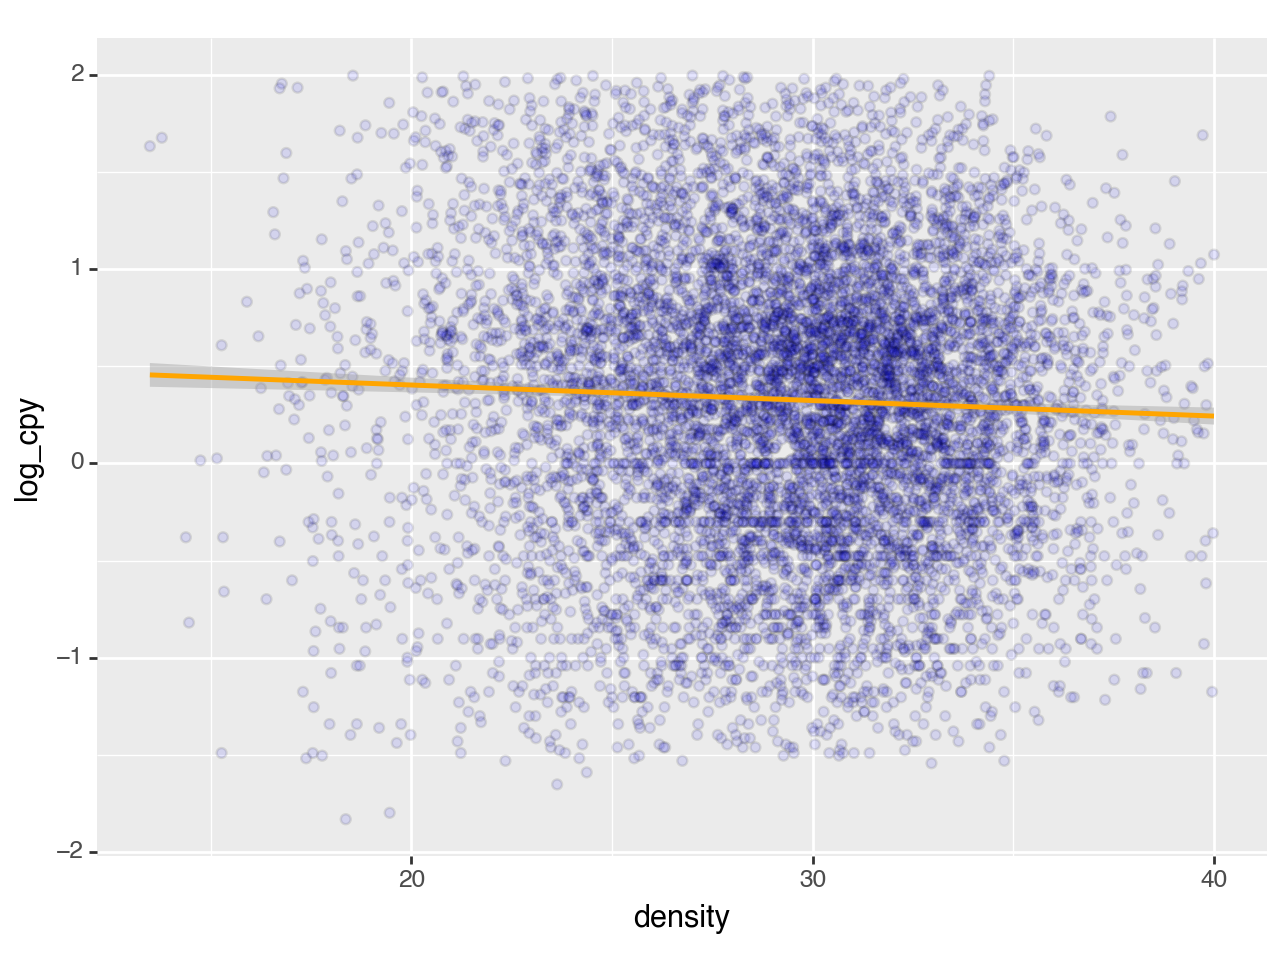

<Figure Size: (640 x 480)>

In [225]:
# log?
df["log_cpy"] = np.log10(df["citations_per_year"])
(
    pn.ggplot(
        df,
        mapping=pn.aes(x="density", y="log_cpy")
    )
    + pn.geom_point(fill="blue", alpha=0.1,)
    + pn.geom_smooth(color="orange")
    # + pn.xlim(10, 20)
)

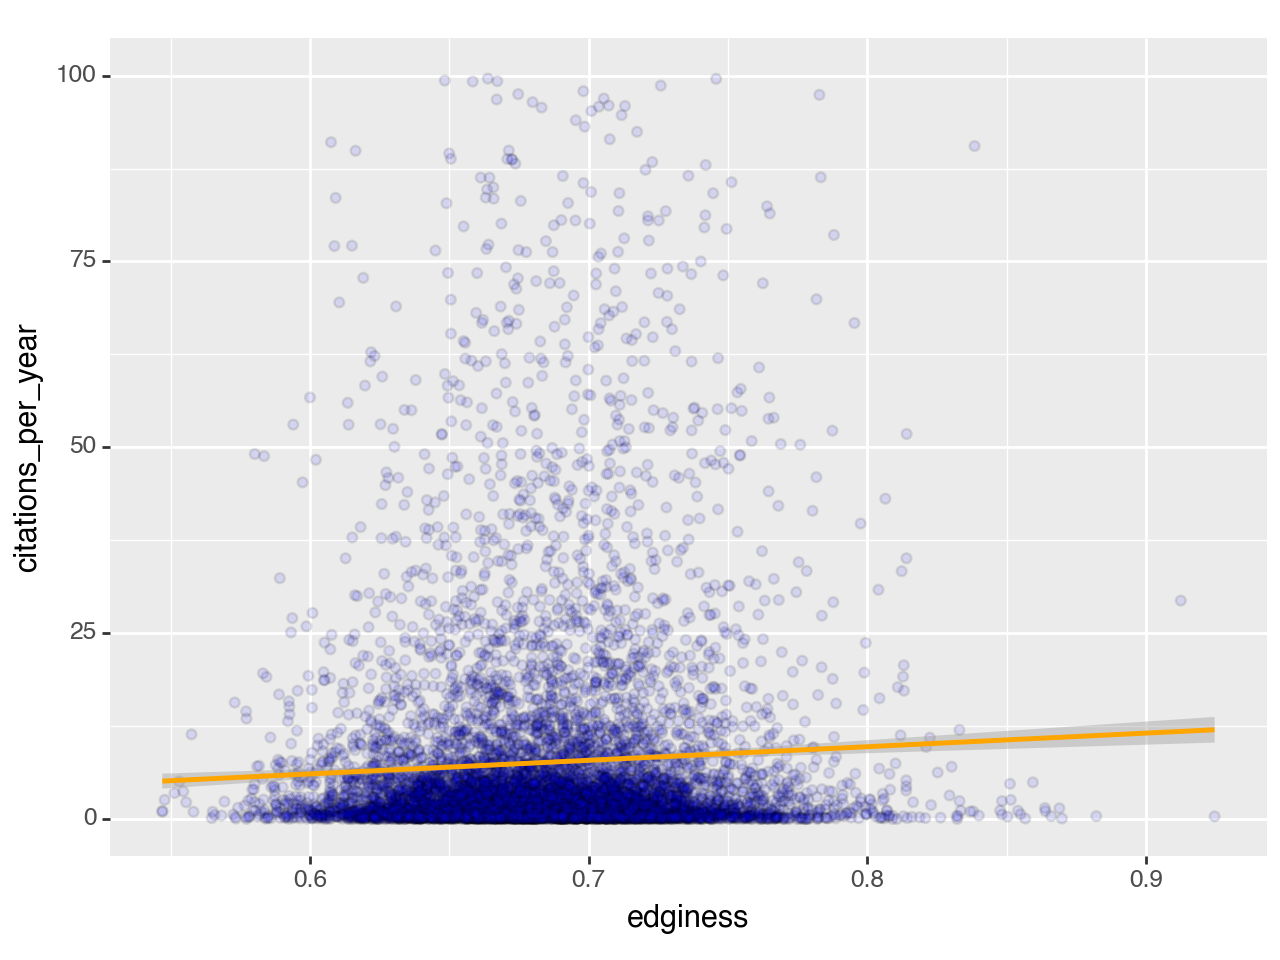

<Figure Size: (640 x 480)>

In [226]:
# asymmetry

(
    pn.ggplot(
        df,
        mapping=pn.aes(x="edginess", y="citations_per_year")
    )
    + pn.geom_point(fill="blue", alpha=0.1,)
    + pn.geom_smooth(color="orange")
    # + pn.xlim(10, 18)
    + pn.ylim(0, 100)
)

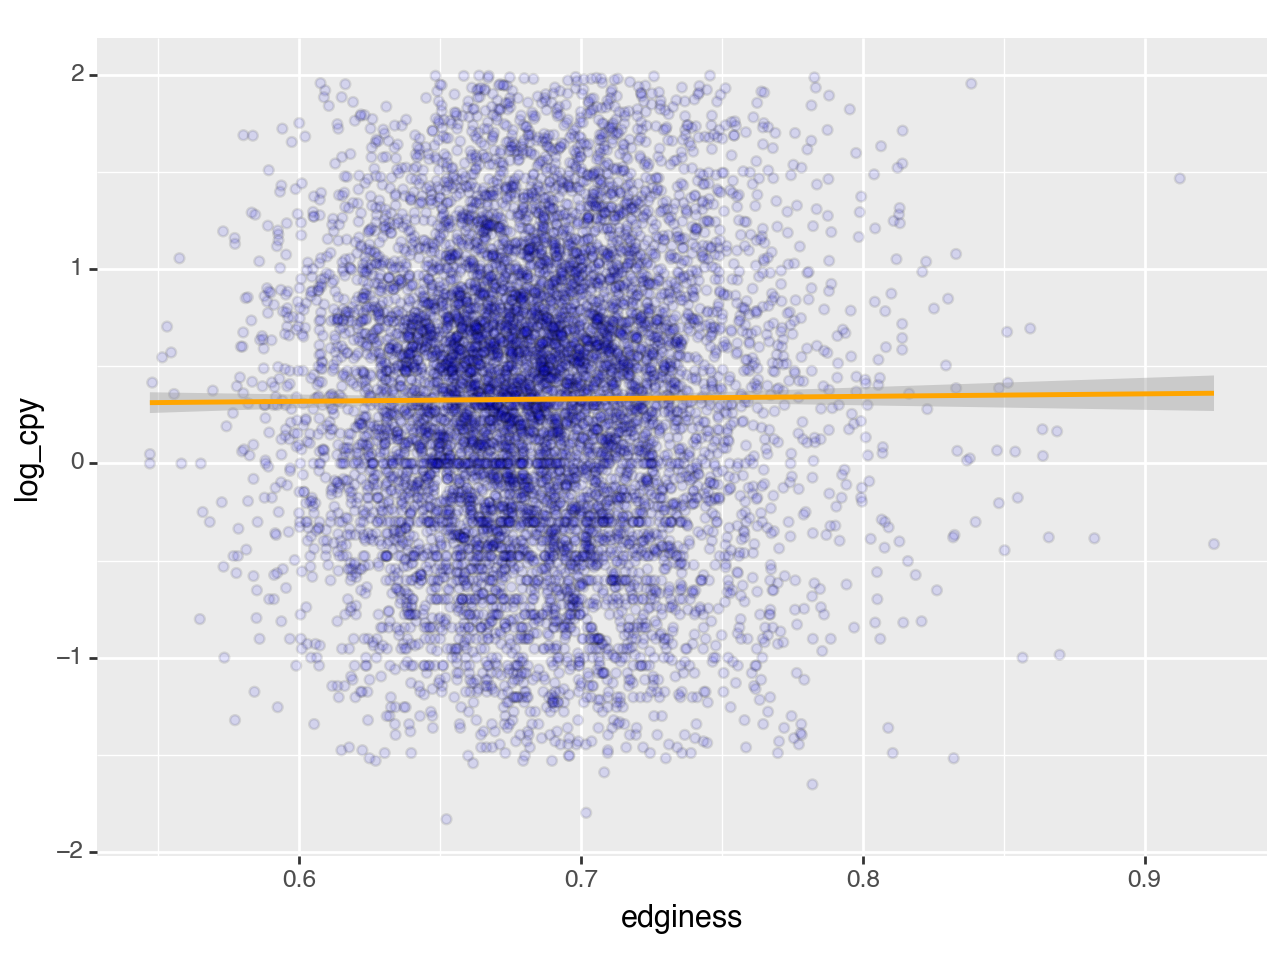

<Figure Size: (640 x 480)>

In [227]:
# asymmetry

(
    pn.ggplot(
        df,
        mapping=pn.aes(x="edginess", y="log_cpy")
    )
    + pn.geom_point(fill="blue", alpha=0.1,)
    + pn.geom_smooth(color="orange")
    # + pn.xlim(10, 18)
    # + pn.ylim(0, 100)
)

normalizem

In [228]:
normalize = lambda arr: (arr - np.nanmean(arr)) / np.nanstd(arr)

density = normalize(df["density"])
edginess = normalize(df["edginess"])

In [229]:
df_n = pd.DataFrame(
    list(zip(density, edginess, citations_per_year, df["log_cpy"])),
    columns=["density", "edginess", "citations_per_year", "log_cpy"],
)
df_n

density  edginess  citations_per_year   log_cpy
0    -0.461545  0.129928                 NaN  1.421604
1    -0.589131 -0.767093           26.400000  0.176091
2    -0.941189 -0.267693            1.500000  1.161368
3     0.716745  0.682868           12.845070  1.146128
4    -0.433023 -0.351190           14.500000  1.059437
...        ...       ...                 ...       ...
8463 -0.247375  1.307360           12.256410  0.439333
8464  0.442691 -0.973157           12.911765 -0.176091
8465  0.086062  0.722789            4.913043  0.662758
8466 -0.433764  0.504258           43.680851  1.003930
8467 -0.524439  1.107730            2.516129 -0.903090

[8468 rows x 4 columns]

geom_point : Removed 1351 rows containing missing values.


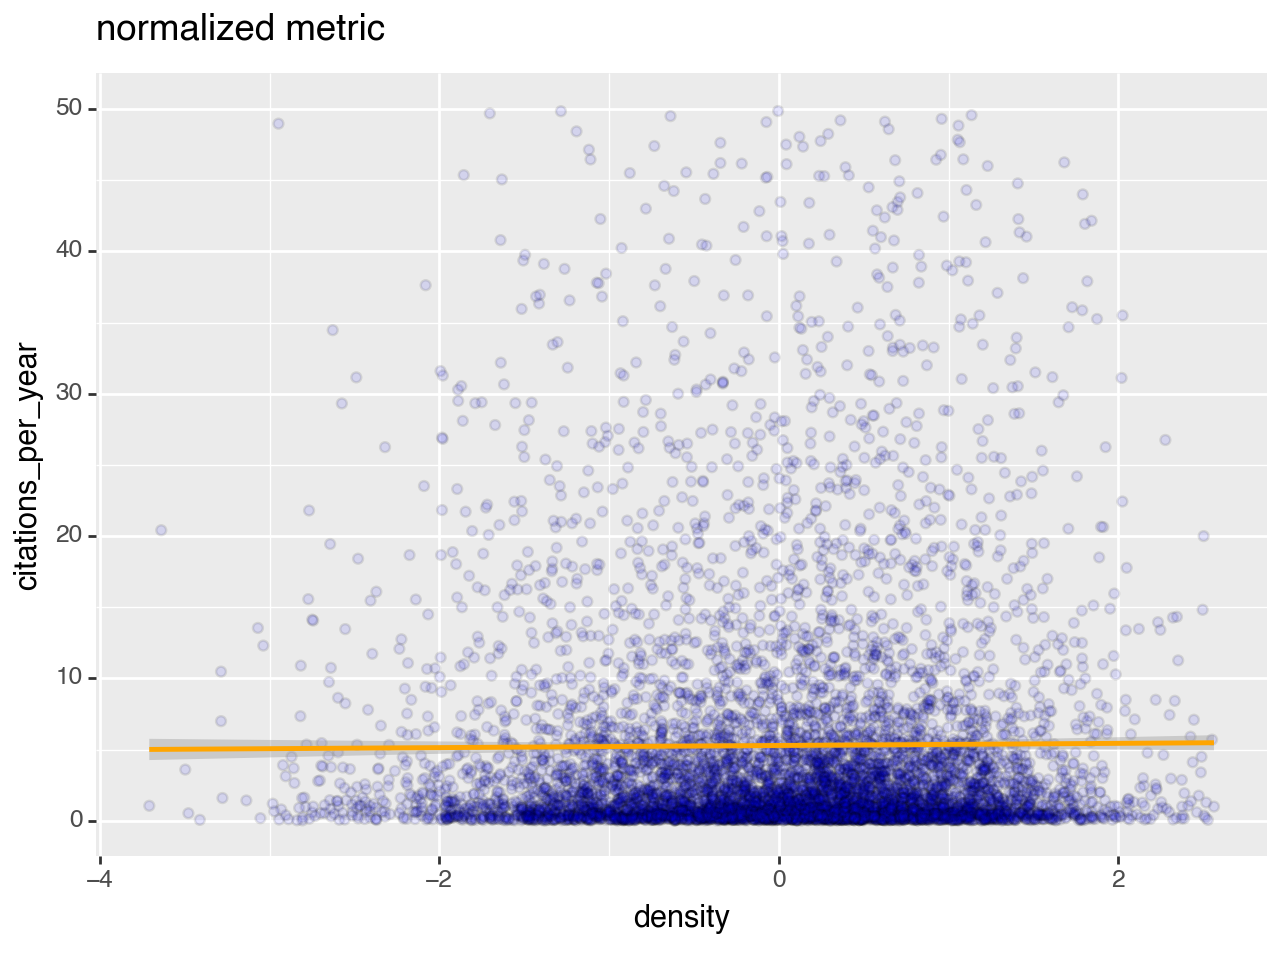

<Figure Size: (640 x 480)>

In [230]:
# This doesn't make much sense because edginess is already normalized to 0,1
(
    pn.ggplot(
        df_n,
        mapping=pn.aes(x="density", y="citations_per_year")
    )
    + pn.geom_point(fill="blue", alpha=0.1,)
    + pn.geom_smooth(color="orange")
    # + pn.xlim(0, 5)
    + pn.ylim(0, 50)
    + pn.ggtitle("normalized metric")
)

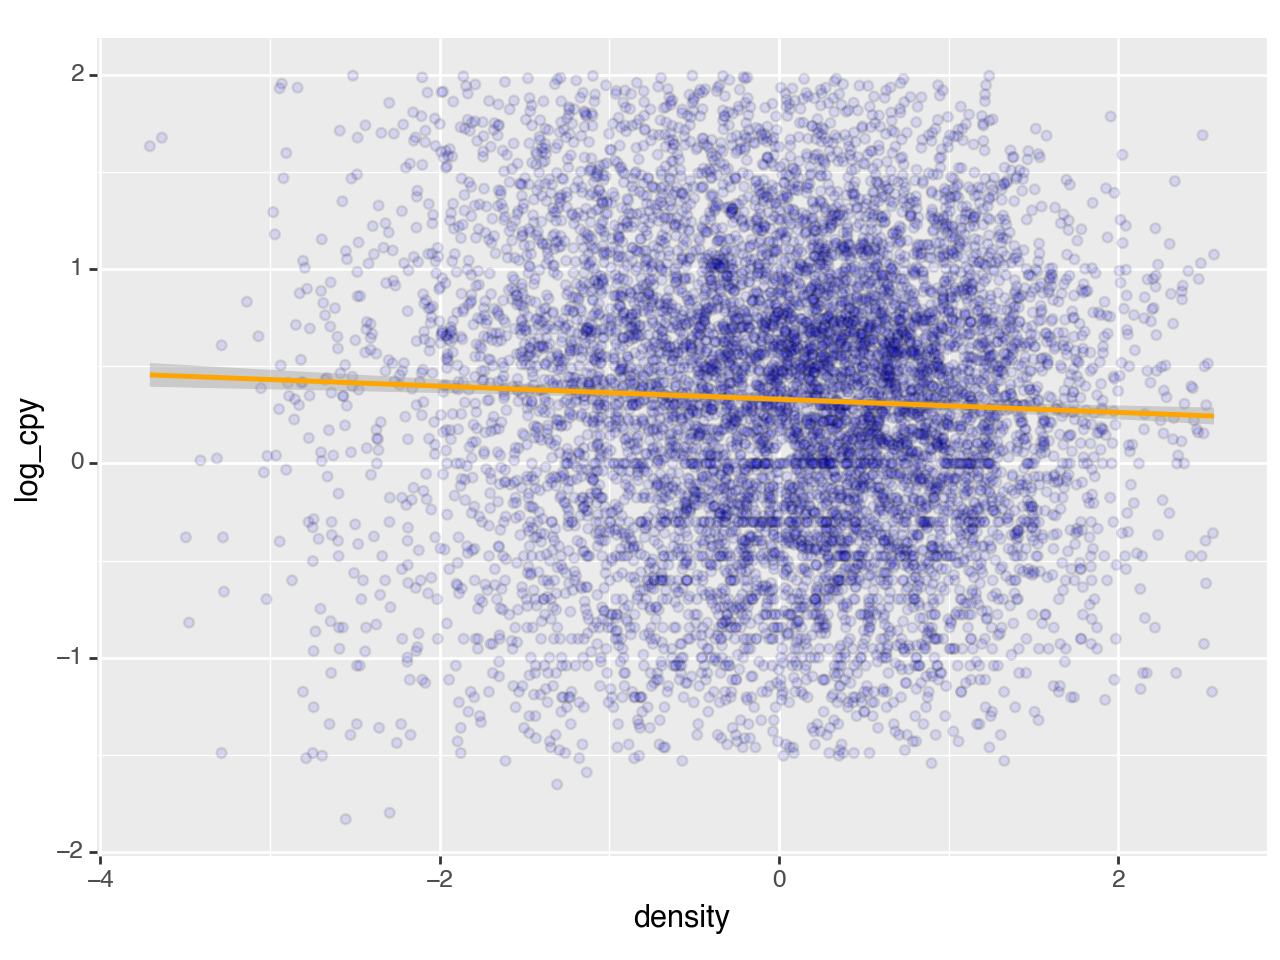

<Figure Size: (640 x 480)>

In [231]:
(
    pn.ggplot(
        df_n,
        mapping=pn.aes(x="density", y="log_cpy")
    )
    + pn.geom_point(fill="blue", alpha=0.1,)
    + pn.geom_smooth(color="orange")
    # + pn.xlim(10, 20)
)

geom_point : Removed 2457 rows containing missing values.


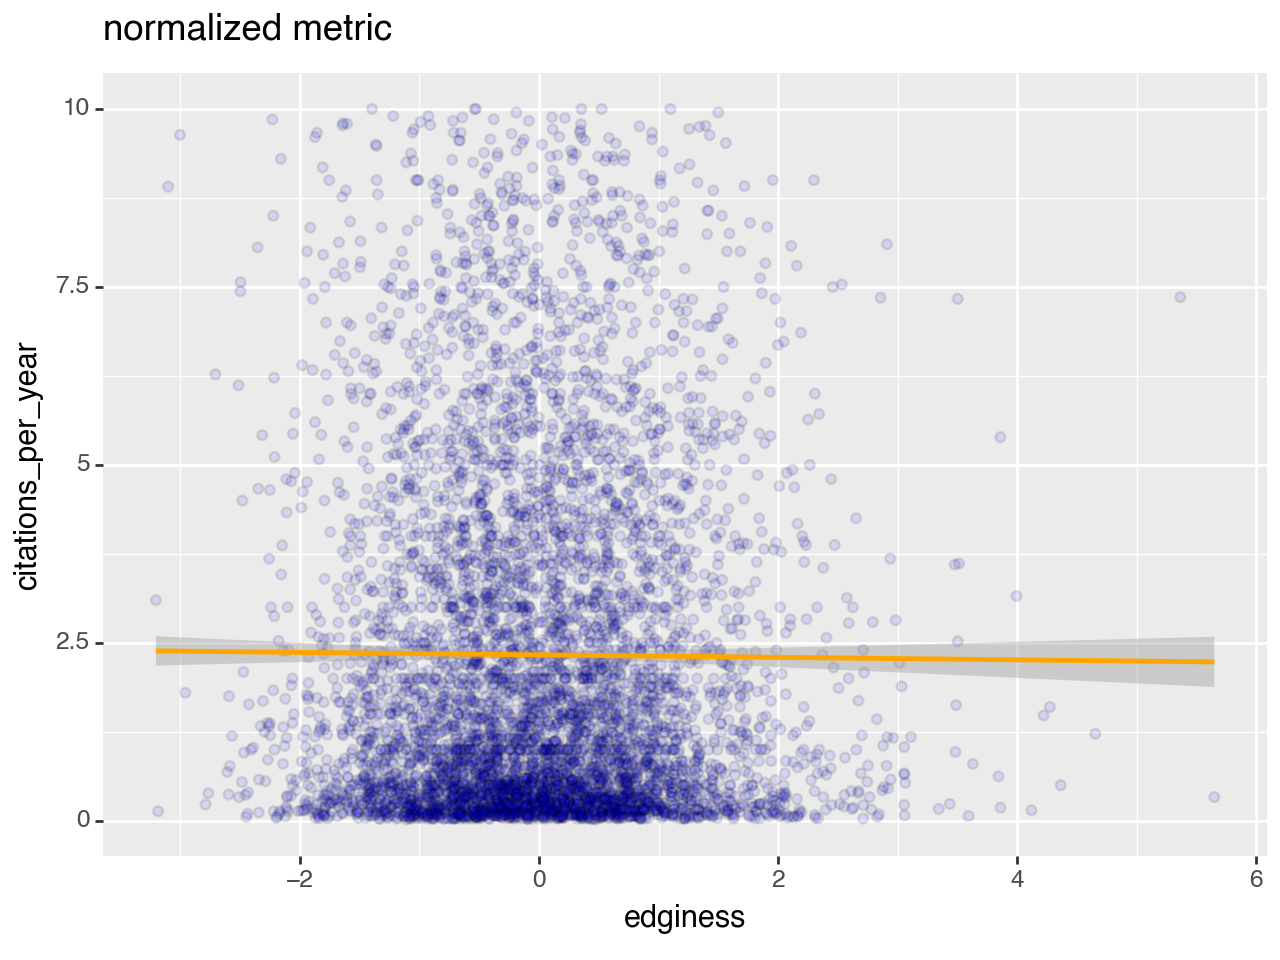

<Figure Size: (640 x 480)>

In [232]:
# This doesn't make much sense because edginess is already normalized to 0,1
(
    pn.ggplot(
        df_n,
        mapping=pn.aes(x="edginess", y="citations_per_year")
    )
    + pn.geom_point(fill="blue", alpha=0.1,)
    + pn.geom_smooth(color="orange")
    # + pn.xlim(10, 18)
    + pn.ylim(0, 10)
    + pn.ggtitle("normalized metric")
)

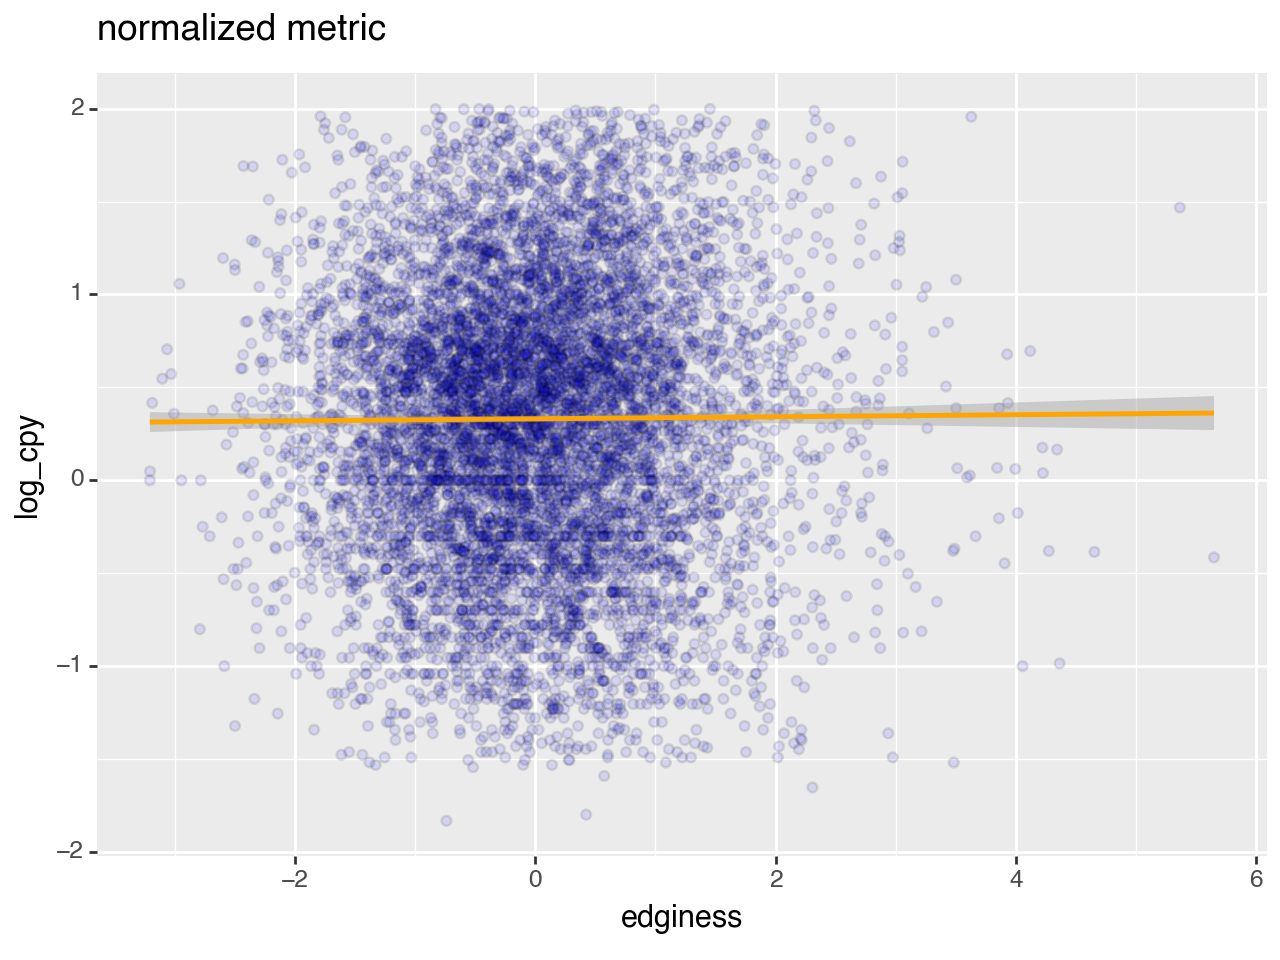

<Figure Size: (640 x 480)>

In [233]:
# This doesn't make much sense because edginess is already normalized to 0,1
(
    pn.ggplot(
        df_n,
        mapping=pn.aes(x="edginess", y="log_cpy")
    )
    + pn.geom_point(fill="blue", alpha=0.1,)
    + pn.geom_smooth(color="orange")
    + pn.ggtitle("normalized metric")
)

In [234]:
np.std(df["citations_per_year"])

14.137575201581097

In [235]:
np.mean(df["citations_per_year"])

7.624397441935964

against each other

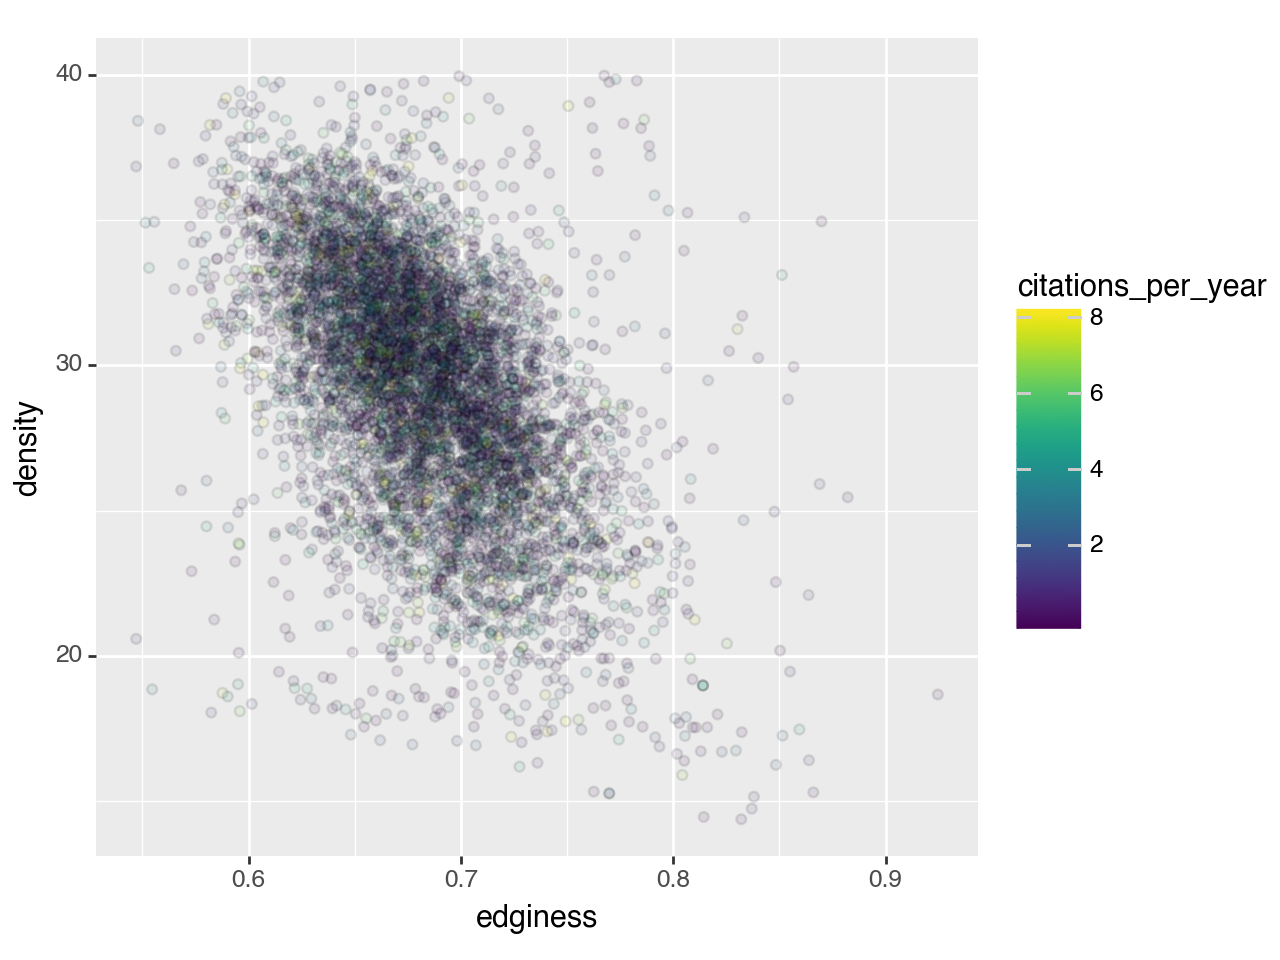

<Figure Size: (640 x 480)>

In [236]:
# not normalized

# also remove citations per year more than a few std devs
# for now just truncate after 100
df_a = df[df["citations_per_year"] <= 8] # or even less

# how to reduce overplotting? Can I make the hotter colors appear on top?
(
    pn.ggplot(
        df_a,
        mapping=pn.aes(x="edginess", y="density")
    )
    + pn.geom_point(
        # fill="blue", 
        mapping=pn.aes(fill="citations_per_year"),
        alpha=0.1,
        )
)

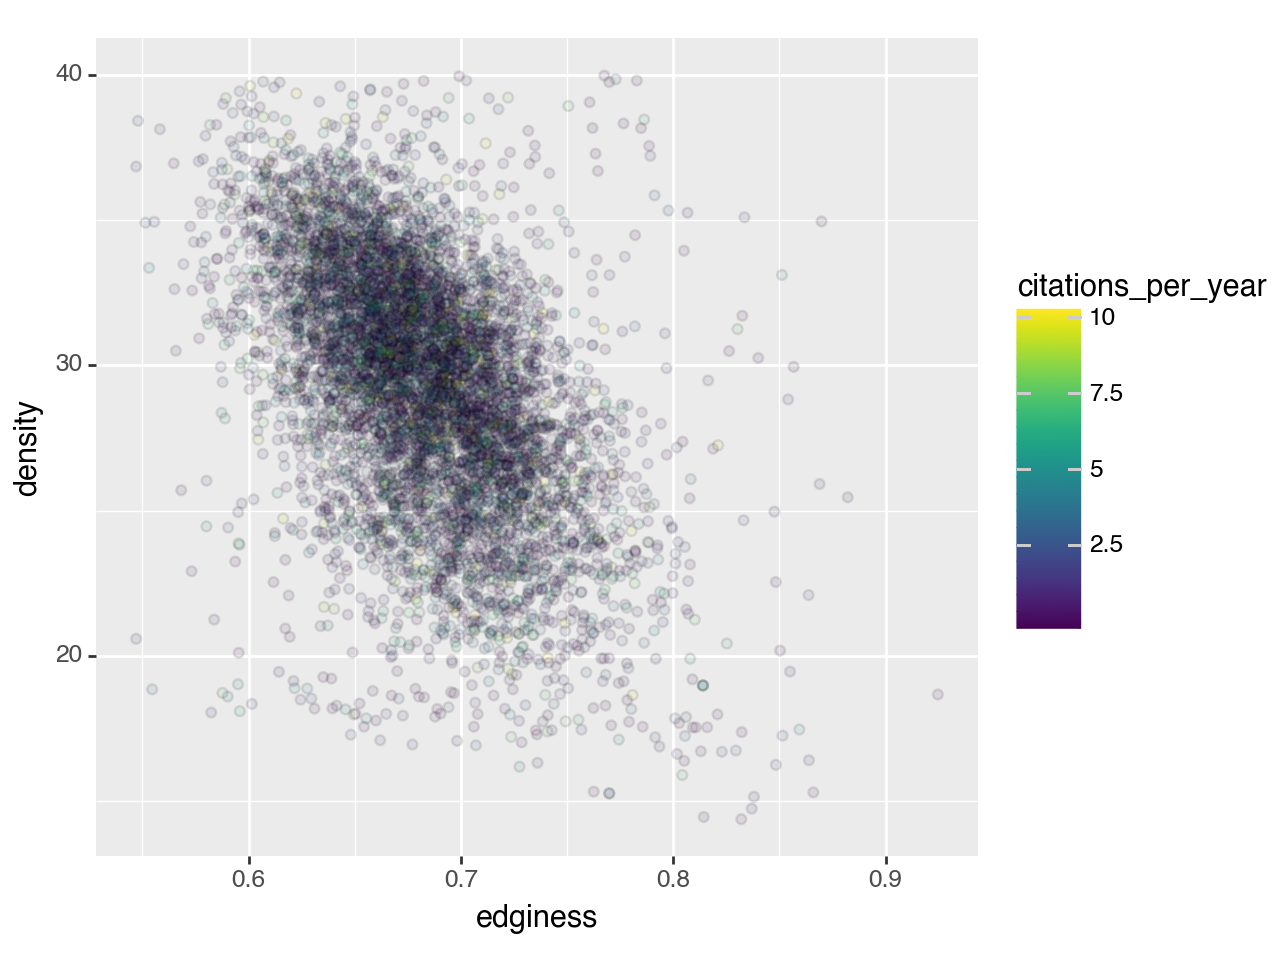

<Figure Size: (640 x 480)>

In [237]:
# let's only plot pubs for high cites per year
df_b = df[df["citations_per_year"] >= 0]
df_b = df[df["citations_per_year"] <= 10]

# how to reduce overplotting? Can I make the hotter colors appear on top?
(
    pn.ggplot(
        df_b,
        mapping=pn.aes(x="edginess", y="density")
    )
    + pn.geom_point(
        # fill="blue", 
        mapping=pn.aes(fill="citations_per_year"),
        alpha=0.1,
        )
)

this does not look like the distribution that zach had.